Importing libraries

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd
from glob import glob
import os
from matplotlib.patches import Rectangle
from matplotlib import pyplot
import matplotlib.patches as patches
dirPath = '../input/rsna-pneumonia-detection-challenge/'
det_class_path =  dirPath + '/stage_2_detailed_class_info.csv'
train_labels_path =  dirPath + '/stage_2_train_labels.csv'
train_img_path = dirPath + '/stage_2_train_images/'

**Training dataset**

This CSV file contains training set patientIds, boxes, and target.

In [3]:
# Read training dataset
train_df = pd.read_csv(train_labels_path)
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')
train_df.head()

There are 30227 rows and 6 columns in this data frame


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


There are patients who have more than 1 box in the image. So, the maximum number of box in image are 4 and for each patient, there are 4 rows with different x,y, width, and height.
Here are some samples for further testing.

In [4]:
train_df.groupby(['patientId']).size().reset_index(name='counts').sort_values(['counts'], ascending=False).head()

,patientId,counts
11018,76f71a93-8105-4c79-a010-0cfa86f0061a,4
2041,1bf08f3b-a273-4f51-bafa-b55ada2c23b5,4
826,0ab261f9-4eb5-42ab-a9a5-e918904d6356,4
1128,0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d,4
2052,1c44e0a4-4612-438f-9a83-8d5bf919cb67,4


The values below show the number of boxes and the patients that have that number.

In [5]:
box_df = train_df.groupby(['patientId']).size().reset_index(name='counts')
box_df = box_df.groupby(['counts']).size().reset_index(name='patients')
print(box_df)

   counts  patients
0       1     23286
1       2      3266
2       3       119
3       4        13


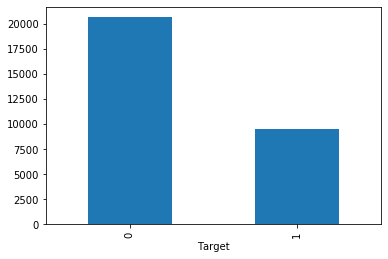

In [6]:
train_df.groupby('Target').size().plot.bar()

**Unique Id Check**

"PatientId" has an identification number for each patient. There are two possibilities.
1. Patients with several images.
2. Patients with several boxes.
In the pervious step, there are different rows for patients who have more than one boxes in their images.

We'll check if there are more than one image for each patient.


In [7]:
print(f"The total patient ids are {train_df['patientId'].count()}, from those the unique ids are {train_df['patientId'].value_counts().shape[0]} ")

The total patient ids are 30227, from those the unique ids are 26684 


**Detailed Class Info**

This CSV file contains detailed labels.
There is no missing value in this file.

In [8]:
df_det_class = pd.read_csv(det_class_path)
print(f'There are {df_det_class.shape[0]} rows and {df_det_class.shape[1]} columns in this data frame')
print(f'There are {df_det_class.isna().sum().sum()} null value rows')
df_det_class.head()


There are 30227 rows and 2 columns in this data frame
There are 0 null value rows


,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


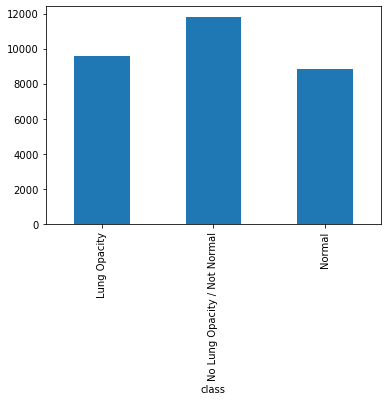

In [9]:
df_det_class.groupby('class').size().plot.bar()

Combine detail and label datasets

In [10]:
comb_df = pd.merge(train_df, df_det_class, how='inner', on='patientId')
print(comb_df.shape[0], 'combined cases')
comb_df.head()

37629 combined cases


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [11]:
comb_df.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

,class,Target,Patient Count
0,Lung Opacity,1,16957
1,No Lung Opacity / Not Normal,0,11821
2,Normal,0,8851


**Image Dataset**
directory containing training set raw image (DICOM) files

In [12]:
image_df = pd.DataFrame({'path': glob(os.path.join(train_img_path, '*.dcm'))})
image_df['patientId'] = image_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print(f'There are {image_df.shape[0]} rows and {image_df.shape[1]} columns in this data frame')
print(f'There are {image_df.isna().sum().sum()} null value rows')
image_df.head()

There are 26684 rows and 2 columns in this data frame
There are 0 null value rows


,path,patientId
0,../input/rsna-pneumonia-detection-challenge//s...,3e120bed-fc23-42ac-85e6-59a28a1d215a
1,../input/rsna-pneumonia-detection-challenge//s...,e01cee30-c1b4-4034-8a52-bda150e93bd4
2,../input/rsna-pneumonia-detection-challenge//s...,32652bc7-21e2-4aa4-ae0c-461950e4c131
3,../input/rsna-pneumonia-detection-challenge//s...,3fb227fe-ba26-4682-ae1f-0e19dee31876
4,../input/rsna-pneumonia-detection-challenge//s...,45e92e87-9e8e-4783-ba97-c032c17864da


Based on the below data, each pateint has only one image.


In [13]:
image_df.groupby(['patientId']).size().reset_index(name='counts').sort_values(['counts'], ascending=False).head()

,patientId,counts
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,1
17928,b3c66cb2-3aa5-4b2f-ba06-19ea7c5efde2,1
17796,b270f32c-a58e-4e35-97ac-01540b2140e9,1
17795,b270a010-9969-43bd-ae89-2a3c3f7b0d21,1
17794,b26d8cd0-8a4c-4f77-9f33-7a5292bed838,1


* Combine with the label dataframe with the image.

In [14]:
comb_img_df = pd.merge(comb_df, image_df, on='patientId',
                        how='left').sort_values('patientId')

comb_img_df.head(5)

,patientId,x,y,width,height,Target,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,../input/rsna-pneumonia-detection-challenge//s...
35875,000924cf-0f8d-42bd-9158-1af53881a557,NaN,NaN,NaN,NaN,0,Normal,../input/rsna-pneumonia-detection-challenge//s...
35876,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,../input/rsna-pneumonia-detection-challenge//s...
35877,000db696-cf54-4385-b10b-6b16fbb3f985,316.0,318.0,170.0,478.0,1,Lung Opacity,../input/rsna-pneumonia-detection-challenge//s...
35878,000db696-cf54-4385-b10b-6b16fbb3f985,660.0,375.0,146.0,402.0,1,Lung Opacity,../input/rsna-pneumonia-detection-challenge//s...


Investigate single Image

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 245.0000 and the minimum is 0.0000
The mean value of the pixels is 120.1918 and the standard deviation is 73.8736


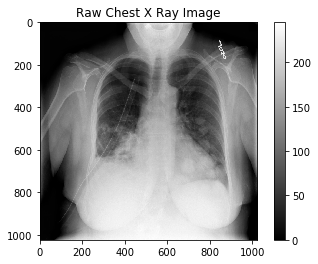

In [15]:
# Get the first image that was listed in the comb_img_df dataframe

d = pydicom.read_file(comb_img_df['path'][0])
im = d.pixel_array

plt.imshow(im, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {im.shape[0]} pixels width and {im.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {im.max():.4f} and the minimum is {im.min():.4f}")
print(f"The mean value of the pixels is {im.mean():.4f} and the standard deviation is {im.std():.4f}")

In [73]:

# Function to load image with boxes

def draw(patArr):
    
    if  patArr:
        for pat in patArr:
            df = comb_img_df[comb_img_df['patientId'] == pat]
            img_data = pydicom.read_file((df['path'].iloc[0]))
            imageArea, axes = pyplot.subplots(1)
            axes.imshow(img_data.pixel_array, cmap=pyplot.cm.bone)
            print(f'Patient class is {df["class"].iloc[0]} and target is {df["Target"].iloc[0]}')
                        
            for index, row in df.iterrows():
                if row["Target"] == 1 :
                
                    x, y, width, height  = row['x'], row['y'], row['width'], row['height']
                    #print("Box", index, ": x, y, width , height ", x, y, width, height)
                    box = patches.Rectangle((x, y), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
                    axes.add_patch(box)
            pyplot.show()  
    else:
        print('Patient List is empty')

Draw some sample images with boxes

Patient class is Lung Opacity and target is 1


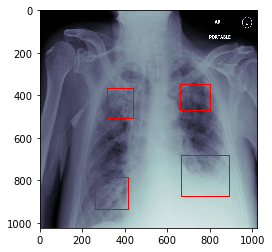

Patient class is Lung Opacity and target is 1


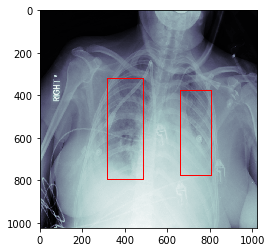

Patient class is No Lung Opacity / Not Normal and target is 0


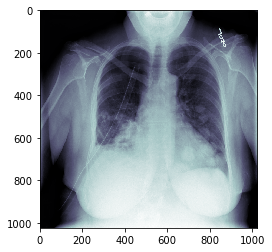

Patient class is Normal and target is 0


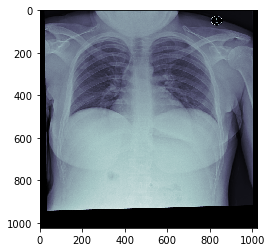

In [74]:
patArr = ['1c44e0a4-4612-438f-9a83-8d5bf919cb67', '000db696-cf54-4385-b10b-6b16fbb3f985', '0004cfab-14fd-4e49-80ba-63a80b6bddd6','000924cf-0f8d-42bd-9158-1af53881a557']
draw(patArr)